# EDA and data cleaning

In this notebook, we will go over the data we have and perform EDA and data cleaning.

In [130]:
# imports
import pandas as pd 
import matplotlib.pyplot as plt 
# for modifying xaxis ticks
from matplotlib.ticker import FuncFormatter
import numpy as np 
import seaborn as sns 
import re
from collections import Counter
import geopandas as gpd 
#plot city map
import folium
# color map for folium
import branca.colormap as cm


## Assumptions we have made so far

- our model will focus on price range less than 2000 per night
- Assumptions about the occupancy rates and minimum booking
- Model would not perform well in some zips without that much data

## Recommendations:
- get more accurate data on occupancy rates or find ways to better model it
- more detailed data on the actual house price for listing 

## Dropping unnecessary columns
We will start our cleaning process by dropping the columns we are sure we dont need.

In [131]:
# read the preprocessed data
df = pd.read_csv('./../data/austin_listings_processed.csv')
print(f'the size of our data is {df.shape}')
df.head(2)

C:\Users\masou\AppData\Local\Temp\ipykernel_10736\3186278372.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./../data/austin_listings_processed.csv')


the size of our data is (47037, 81)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,occ_rate_calendar,active_duration_days,occ_rate_70,occ_rate_50,occ_rate_30,time_quarter
0,5456,https://www.airbnb.com/rooms/5456,20231215200307,2023-12-16,city scrape,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,NaN,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,Sylvia,2009-02-16,"Austin, TX",I am a licensed Real Estate Broker and owner o...,within an hour,100%,97%,t,https://a0.muscache.com/im/users/8028/profile_...,https://a0.muscache.com/im/users/8028/profile_...,East Downtown,1.0,4.0,"['email', 'phone']",t,t,"Austin, Texas, United States",78702,NaN,30.26057,-97.73441,Entire guesthouse,Entire home/apt,3,NaN,1 bath,NaN,2.0,[],$101.00,2,90,2.0,2.0,90.0,90.0,2.0,90.0,NaN,t,21,51,74,330,2023-12-16,668,47,1,2009-03-08,2023-11-20,4.84,4.88,4.86,4.89,4.83,4.73,4.79,NaN,f,1,1,0,0,3.71,0.3,5390.0,0.700000,0.700000,0.7,Q4
1,5769,https://www.airbnb.com/rooms/5769,20231215200307,2023-12-16,previous scrape,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,NaN,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,Elizabeth,2009-02-19,"Austin, TX",We're easygoing professionals that enjoy meeti...,within an hour,100%,88%,t,https://a0.muscache.com/im/users/8186/profile_...,https://a0.muscache.com/im/users/8186/profile_...,SW Williamson Co.,1.0,4.0,"['email', 'phone', 'work_email']",t,t,"Austin, Texas, United States",78729,NaN,30.45697,-97.78422,Private room in home,Private room,2,NaN,1 shared bath,NaN,1.0,[],NaN,1,14,1.0,1.0,14.0,14.0,1.0,14.0,NaN,NaN,0,0,0,0,2023-12-16,294,20,2,2010-04-10,2023-12-07,4.91,4.90,4.87,4.91,4.94,4.76,4.92,NaN,f,1,0,1,0,1.76,0.7,5404.0,0.388601,0.544041,0.7,Q4


In [132]:
pd.set_option('display.max_columns', None)

In [133]:
# print list of the columns
print(list(df.columns))


['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

Let us retain the columns we might wanna use later. Only drop the columns that won't be used for sure. 

In [134]:

columns_to_keep = ['id', 'name', 'description','neighborhood_overview',
                   'host_is_superhost', 'neighbourhood_cleansed', 'property_type', 'room_type', 
                   'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
                   'number_of_reviews', 'review_scores_rating','occ_rate_50', 'time_quarter',
                   # host analysis
                   'host_id'
                   ]
df = df[columns_to_keep]
# rename columns if needed
df.rename(columns={'neighbourhood_cleansed': 'zipcode',
                   'occ_rate_50': 'occupancy_rate'}, inplace=True)
df.head(3)


,id,name,description,neighborhood_overview,host_is_superhost,zipcode,property_type,room_type,bathrooms_text,bedrooms,beds,amenities,price,number_of_reviews,review_scores_rating,occupancy_rate,time_quarter,host_id
0,5456,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,NaN,My neighborhood is ideally located if you want...,t,78702,Entire guesthouse,Entire home/apt,1 bath,NaN,2.0,[],$101.00,668,4.84,0.700000,Q4,8028
1,5769,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,NaN,Quiet neighborhood with lots of trees and good...,t,78729,Private room in home,Private room,1 shared bath,NaN,1.0,[],NaN,294,4.91,0.544041,Q4,8186
2,6413,Guesthouse in Austin · ★4.97 · Studio · 1 bed ...,NaN,Travis Heights is one of the oldest neighborho...,f,78704,Entire guesthouse,Entire home/apt,1 bath,NaN,1.0,[],NaN,120,4.97,0.700000,Q4,13879


Let us start our analysis by looking at the nans.

In [135]:
df.isna().sum().sort_values(ascending=False)

bedrooms                 17307
neighborhood_overview    16070
description              12515
price                     2135
host_is_superhost         2058
beds                       363
bathrooms_text              34
time_quarter                 0
occupancy_rate               0
review_scores_rating         0
number_of_reviews            0
id                           0
amenities                    0
name                         0
room_type                    0
property_type                0
zipcode                      0
host_id                      0
dtype: int64

Since price is a very import feature in our data, let us dive deeper into why it has 2000 missing values.

## Missing prices

In [136]:
df[df['price'].isna()].head(5)

,id,name,description,neighborhood_overview,host_is_superhost,zipcode,property_type,room_type,bathrooms_text,bedrooms,beds,amenities,price,number_of_reviews,review_scores_rating,occupancy_rate,time_quarter,host_id
1,5769,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,NaN,Quiet neighborhood with lots of trees and good...,t,78729,Private room in home,Private room,1 shared bath,NaN,1.0,[],NaN,294,4.91,0.544041,Q4,8186
2,6413,Guesthouse in Austin · ★4.97 · Studio · 1 bed ...,NaN,Travis Heights is one of the oldest neighborho...,f,78704,Entire guesthouse,Entire home/apt,1 bath,NaN,1.0,[],NaN,120,4.97,0.700000,Q4,13879
14,69810,Guesthouse in Austin · ★4.98 · 1 bedroom · 1 b...,NaN,"Located in the cool Dawson area, about two mil...",f,78704,Entire guesthouse,Entire home/apt,1 bath,NaN,1.0,[],NaN,445,4.98,0.700000,Q4,82762
18,219168,Rental unit in Austin · ★4.88 · Studio · 1 bed...,NaN,Despite its proximity to South Congress and th...,f,78704,Entire rental unit,Entire home/apt,1 bath,NaN,1.0,[],NaN,8,4.88,0.043080,Q4,1134580
19,72833,Guesthouse in Austin · ★4.91 · 1 bedroom · 1 b...,NaN,Peaceful neighborhood street in central Austin...,t,78731,Entire guesthouse,Entire home/apt,1 bath,NaN,1.0,[],NaN,413,4.91,0.700000,Q4,378744


Let us see if we can find further insight towards what listings have missing prices.

In [137]:
df[df['price'].isna()].describe(include='object')

,name,description,neighborhood_overview,host_is_superhost,property_type,room_type,bathrooms_text,amenities,price,time_quarter
count,2135,0,1333,2134,2135,2135,2132,2135,0,2135
unique,1151,0,1276,2,40,4,18,1,0,1
top,Rental unit in Austin · 1 bedroom · 1 bed · 1 ...,NaN,"Great location, close to everything Austin has...",f,Entire home,Entire home/apt,1 bath,[],NaN,Q4
freq,110,NaN,11,1828,631,1555,970,2135,NaN,2135


In [138]:
df[df['price'].isna()].describe()


,id,zipcode,bedrooms,beds,number_of_reviews,review_scores_rating,occupancy_rate,host_id
count,2.135000e+03,2135.000000,0.0,2122.000000,2135.000000,2135.000000,2135.000000,2.135000e+03
mean,1.153142e+17,78723.140984,NaN,2.052309,23.096956,4.794993,0.189055,8.627870e+07
std,2.717539e+17,20.665209,NaN,1.447688,50.841213,0.444607,0.230274,1.110281e+08
min,5.769000e+03,78701.000000,NaN,1.000000,1.000000,0.000000,0.001850,5.985000e+03
25%,1.316979e+07,78704.000000,NaN,1.000000,2.000000,4.775000,0.024379,1.139570e+07
50%,2.368026e+07,78722.000000,NaN,2.000000,6.000000,4.970000,0.076225,4.212014e+07
75%,4.703812e+07,78744.000000,NaN,3.000000,21.500000,5.000000,0.266056,1.166989e+08
max,1.029898e+18,78759.000000,NaN,14.000000,687.000000,5.000000,0.700000,5.358769e+08


In [139]:
df[df['price'].isna()]['id'].nunique()

2135

As we can see, all of the missing prices have happened during data scraping in Q4 so there could be some issues at that time (they all have unique id's as well). Looking further, we can see that none of the listings with missing price have description either but this may not be a significant finding because description column has a lot of missing values, in addition to the ones with no price (similar observation for bedrooms).   

Let us see what is the total number of unique id's for our listings.

In [140]:
df['id'].nunique()

15175

This means we will have a lot of listings that have been listed at different times. We might be able to use price information for that specific property by looking at the prices it was listed for at other times. 

In [141]:
missing_price_ids = list(df[df['price'].isna()]['id'].unique())

In [142]:
df[df['id'] == missing_price_ids[0]]

,id,name,description,neighborhood_overview,host_is_superhost,zipcode,property_type,room_type,bathrooms_text,bedrooms,beds,amenities,price,number_of_reviews,review_scores_rating,occupancy_rate,time_quarter,host_id
1,5769,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,NaN,Quiet neighborhood with lots of trees and good...,t,78729,Private room in home,Private room,1 shared bath,NaN,1.0,[],NaN,294,4.91,0.544041,Q4,8186
12265,5769,Home in Austin · ★4.90 · 1 bedroom · 1 bed · 1...,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,t,78729,Private room in home,Private room,1 shared bath,NaN,1.0,"[""Wifi \u2013 47 Mbps"", ""Lock on bedroom door""...",$45.00,290,4.90,0.549346,Q3,8186
24012,5769,Home in Austin · ★4.90 · 1 bedroom · 1 bed · 1...,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,NaN,78729,Private room in home,Private room,1 shared bath,NaN,1.0,"[""Host greets you"", ""Essentials"", ""Shampoo"", ""...",$42.00,285,4.90,0.546291,Q2,8186
35716,5769,NW Austin Room,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,t,78729,Private room in home,Private room,1 shared bath,1.0,1.0,"[""Private backyard"", ""Free parking on premises...",$42.00,275,4.90,0.539957,Q1,8186


Let us replace the missing price values with that of the same listing on other times periods. 

In [143]:
#convert currency columns to float when avaialble
df['price'] = df['price'].str.replace('[\$,]', '', regex=True).astype(float)
df['price'].dtype

dtype('float64')

In [144]:
# make a dictionary where the key is the index id for the missing prices and value is the average price for that listing
# based on other times of the year
avrg_price = {}
for i in missing_price_ids:
    avrg_price[i] = df[df['id'] == i]['price'].mean()

# replace the missings with average from other dates
df.loc[df['price'].isna(),'price'] = df[df['price'].isna()].apply(lambda x: avrg_price[x['id']], axis=1)

In [145]:
df['price'].isna().sum()

33

As we can see, we have replaced most of the listings with missing prices with some values from the same listing at other times (data missing not at random). Now, we can go ahead and drop the remaining nan's in the price column. 

In [146]:
df = df.dropna(subset=['price'])
df.isna().sum().sort_values(ascending=False)

bedrooms                 17274
neighborhood_overview    16056
description              12482
host_is_superhost         2058
beds                       363
bathrooms_text              34
price                        0
time_quarter                 0
occupancy_rate               0
review_scores_rating         0
number_of_reviews            0
id                           0
amenities                    0
name                         0
room_type                    0
property_type                0
zipcode                      0
host_id                      0
dtype: int64

## Missing values in bedrooms

An interesting trend we are observing is that we already know all airbnb listings should have information about the number of bedrooms. However, we have a lot of listings without any data for the bedrooms. Similar to what we did with price, let us see if we can find information about the number of bedrooms from earlier listings of the same property and use that in our data.


In [147]:
missing_bedroom_id = df[df['bedrooms'].isna()]['id'].unique()
missing_bedroom = {}
# go over listings with missibg bedroom info and see if the same listing has some bedrooms reported earlier or later in time
for i in missing_bedroom_id:
    # if there are different number of bedrooms reported for the same property, pick up the smaller one (arbitrary decision)
    min_bd = df[df['id'] == i ]['bedrooms'].min()
    missing_bedroom[i] = min_bd

# now replace the nan's in missing bedroom in the same listing has bedrooms reported somewhere else
df.loc[df['bedrooms'].isna(),'bedrooms'] = df[df['bedrooms'].isna()].apply(lambda x: missing_bedroom[x['id']], axis=1)
     

In [148]:
df['bedrooms'].isna().sum()

4431

This reduces the number of missing bedrooms to 4431.

When we look at the listing name column, we can see very interesting information about the home, number of bedrooms, beds, and bathrooms are provided. 

In [149]:
df.iloc[0]['name']

'Guesthouse in Austin · ★4.84 · 1 bedroom · 2 beds · 1 bath'

From this pattern, we can see that the '.' character can be used to separate the string upon. Let us first make sure that all the names in our listing follow the same convention. 

In [150]:
df['name'].apply(lambda x: len(x.split('·'))).value_counts()

5    29971
1    11317
4     5620
3       90
2        6
Name: name, dtype: int64

As we can see, there are a lot of listings that don't follow this naming convenction, let's take a look at them.

In [151]:
df[df['name'].apply(lambda x: len(x.split('·'))) == 1].head(2)

,id,name,description,neighborhood_overview,host_is_superhost,zipcode,property_type,room_type,bathrooms_text,bedrooms,beds,amenities,price,number_of_reviews,review_scores_rating,occupancy_rate,time_quarter,host_id
35715,5456,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,t,78702,Entire guesthouse,Entire home/apt,1 bath,1.0,2.0,"[""Heating"", ""Backyard"", ""Bed linens"", ""Hot wat...",176.0,630,4.84,0.700000,Q1,8028
35716,5769,NW Austin Room,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,t,78729,Private room in home,Private room,1 shared bath,1.0,1.0,"[""Private backyard"", ""Free parking on premises...",42.0,275,4.90,0.539957,Q1,8186


Let us look at the first listing from the list above.

In [152]:
df[df['id'] ==5456]

,id,name,description,neighborhood_overview,host_is_superhost,zipcode,property_type,room_type,bathrooms_text,bedrooms,beds,amenities,price,number_of_reviews,review_scores_rating,occupancy_rate,time_quarter,host_id
0,5456,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,NaN,My neighborhood is ideally located if you want...,t,78702,Entire guesthouse,Entire home/apt,1 bath,1.0,2.0,[],101.0,668,4.84,0.7,Q4,8028
12264,5456,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,Week of July 31 - Aug 10 require min of 5 nig...,My neighborhood is ideally located if you want...,t,78702,Entire guesthouse,Entire home/apt,1 bath,1.0,2.0,"[""Air conditioning"", ""Hot water"", ""Dishes and ...",126.0,657,4.84,0.7,Q3,8028
24007,5456,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,Great central location for walking to Convent...,My neighborhood is ideally located if you want...,t,78702,Entire guesthouse,Entire home/apt,1 bath,1.0,2.0,"[""HDTV with Amazon Prime Video, HBO Max, Hulu,...",107.0,648,4.84,0.7,Q2,8028
35715,5456,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,t,78702,Entire guesthouse,Entire home/apt,1 bath,1.0,2.0,"[""Heating"", ""Backyard"", ""Bed linens"", ""Hot wat...",176.0,630,4.84,0.7,Q1,8028


As we can see, this property has some other listings as well and it looks like after Q1, airbnb has decided to follow the listing convention of using '.' in their names. let us check another listing. 

In [153]:
df[df['id'] ==5769]

,id,name,description,neighborhood_overview,host_is_superhost,zipcode,property_type,room_type,bathrooms_text,bedrooms,beds,amenities,price,number_of_reviews,review_scores_rating,occupancy_rate,time_quarter,host_id
1,5769,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,NaN,Quiet neighborhood with lots of trees and good...,t,78729,Private room in home,Private room,1 shared bath,1.0,1.0,[],43.0,294,4.91,0.544041,Q4,8186
12265,5769,Home in Austin · ★4.90 · 1 bedroom · 1 bed · 1...,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,t,78729,Private room in home,Private room,1 shared bath,1.0,1.0,"[""Wifi \u2013 47 Mbps"", ""Lock on bedroom door""...",45.0,290,4.90,0.549346,Q3,8186
24012,5769,Home in Austin · ★4.90 · 1 bedroom · 1 bed · 1...,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,NaN,78729,Private room in home,Private room,1 shared bath,1.0,1.0,"[""Host greets you"", ""Essentials"", ""Shampoo"", ""...",42.0,285,4.90,0.546291,Q2,8186
35716,5769,NW Austin Room,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,t,78729,Private room in home,Private room,1 shared bath,1.0,1.0,"[""Private backyard"", ""Free parking on premises...",42.0,275,4.90,0.539957,Q1,8186


Let us see how many missing values for bedrooms do we have for listing where the name is using the new convention of using '.' and indicating the number of beds and baths. 

In [154]:
print('number of listing with missing bedrooms that use "." to separate the number of rooms in the listing name (5 dots)')
print(df[df['name'].apply(lambda x: len(x.split('·'))) == 5]['bedrooms'].isna().sum())

number of listing with missing bedrooms that use "." to separate the number of rooms in the listing name (5 dots)
2840


In [155]:
print('number of listing with missing bedrooms that use "." to separate the number of rooms in the listing name (4 dots)')
print(df[df['name'].apply(lambda x: len(x.split('·'))) == 4]['bedrooms'].isna().sum())

number of listing with missing bedrooms that use "." to separate the number of rooms in the listing name (4 dots)
981


In [156]:
print('number of listing with missing bedrooms that use "." to separate the number of rooms in the listing name (3 dots)')
print(df[df['name'].apply(lambda x: len(x.split('·'))) == 3]['bedrooms'].isna().sum())

number of listing with missing bedrooms that use "." to separate the number of rooms in the listing name (3 dots)
24


In [157]:
print('number of listing with missing bedrooms that use "." to separate the number of rooms in the listing name (2 dots)')
print(df[df['name'].apply(lambda x: len(x.split('·'))) == 2]['bedrooms'].isna().sum())

number of listing with missing bedrooms that use "." to separate the number of rooms in the listing name (2 dots)
0


In [158]:
print('number of listing with missing bedrooms that use "." to separate the number of rooms in the listing name (1 dots)')
print(df[df['name'].apply(lambda x: len(x.split('·'))) == 1]['bedrooms'].isna().sum())

number of listing with missing bedrooms that use "." to separate the number of rooms in the listing name (1 dots)
586


It looks like most of the listings that have the number of bedrooms missing should have some indication of the number of bedrooms in their name listing. We will have to regex to extract the bedroom information from this data. The following regex will extract the first number before the words 'bedroom', 'Bedroom', 'bedrooms', or 'Bedrooms'. 

In [159]:
df['bedrooms_extracted'] = df['name'].apply(lambda x: re.search(r'\D*(\d+\.\d+|\d+)\D*(?:bedroom|bedrooms|Bedroom|Bedrooms)',x).group(1) if 
                                            re.search(r'\D*(\d+\.\d+|\d+)\D*(?:bedroom|bedrooms|Bedroom|Bedrooms)',x) else np.nan)                           


In [160]:
# convert the string into int if they are not nan
df['bedrooms_extracted'] = pd.to_numeric(df['bedrooms_extracted'])


In [161]:
df['bedrooms_extracted'].value_counts()

1.0        14505
2.0         8923
3.0         6456
4.0         3030
5.0          949
6.0          335
7.0          146
8.0           60
9.0           30
10.0          23
13.0          10
12.0           8
23.0           4
14.0           4
15.0           3
1940.0         2
11.0           1
78704.0        1
33.0           1
Name: bedrooms_extracted, dtype: int64

In [162]:
df['bedrooms_extracted'].isna().sum()

12513

Now, let us take a look at the column beedrooms and bedrooms_extracted together and see how many listings dont have values in either of these columns.

In [163]:
df[df['bedrooms'].isna() & df['bedrooms_extracted'].isna()].shape

(2346, 19)

In [164]:
df[df['bedrooms'].isna() & df['bedrooms_extracted'].isna()].head(5)

,id,name,description,neighborhood_overview,host_is_superhost,zipcode,property_type,room_type,bathrooms_text,bedrooms,beds,amenities,price,number_of_reviews,review_scores_rating,occupancy_rate,time_quarter,host_id,bedrooms_extracted
2,6413,Guesthouse in Austin · ★4.97 · Studio · 1 bed ...,NaN,Travis Heights is one of the oldest neighborho...,f,78704,Entire guesthouse,Entire home/apt,1 bath,NaN,1.0,[],91.666667,120,4.97,0.700000,Q4,13879,NaN
18,219168,Rental unit in Austin · ★4.88 · Studio · 1 bed...,NaN,Despite its proximity to South Congress and th...,f,78704,Entire rental unit,Entire home/apt,1 bath,NaN,1.0,[],250.000000,8,4.88,0.043080,Q4,1134580,NaN
22,224603,Guesthouse in Austin · ★4.94 · Studio · 1 bed ...,NaN,NaN,t,78751,Entire guesthouse,Entire home/apt,1 bath,NaN,1.0,[],110.000000,116,4.94,0.700000,Q4,1169129,NaN
43,78884,Rental unit in Austin · ★4.78 · Studio · 2 bed...,NaN,The Barton Hills neighborhood is located in Au...,t,78704,Entire rental unit,Entire home/apt,1 bath,NaN,2.0,[],101.000000,199,4.78,0.473922,Q4,2157243,NaN
107,343889,Rental unit in Austin · ★4.75 · Studio · 1 bed...,NaN,"Friendly, walkable residential neighborhood wi...",f,78702,Entire rental unit,Entire home/apt,1 bath,NaN,1.0,[],60.000000,36,4.75,0.505027,Q4,1744639,NaN


It seems like a lot of these places could be studios. What we can do here now is to see what listing has the word studio in it and then assign a value of 0 to its bedrooms_extracted column value. 

In [165]:
df.loc[(df['bedrooms_extracted'].isna() &
       df['name'].str.contains('Studio|studio|STUDIO')),'bedrooms_extracted'] = 0
df[df['bedrooms_extracted'].isna() &
   df['name'].str.contains('Studio|studio|STUDIO')
   ].shape

(0, 19)

Again, going back to the listings with no beedrooms reported in the bedrooms or bedrooms_extracted columns.

In [166]:
df[df['bedrooms'].isna() & df['bedrooms_extracted'].isna()].shape

(478, 19)

If we exclude the listing that are private or shared rooms (we will not be modeling those) we have:

In [167]:
df[df['bedrooms_extracted'].isna() & 
   df['bedrooms'].isna() & 
   df['room_type'].str.contains('Entire home/apt')].shape

(455, 19)

We will only have 455 important listing with no bedroom information (later, we will have to drop these listings). At this time, let us combine the data from bedrooms and bedroom_extracted columns. To do that, we will first check if we have any information about bedroom in the bedroom column itself, if not, we will use that of bedroom extracted. 

In [168]:
df['bedrooms'] = df.apply(lambda x: x['bedrooms'] if not np.isnan(x['bedrooms']) else x['bedrooms_extracted'], axis=1)
df.drop(columns=['bedrooms_extracted'], inplace=True)
df['bedrooms'].isna().sum()

478

Dropping redundant columns.

In [169]:
df = df.drop(columns=['name'])

## Missing superhost information

Let us take a look at the count of missing values again.

In [170]:
df.isna().sum().sort_values(ascending=False)

neighborhood_overview    16056
description              12482
host_is_superhost         2058
bedrooms                   478
beds                       363
bathrooms_text              34
price                        0
time_quarter                 0
occupancy_rate               0
review_scores_rating         0
number_of_reviews            0
id                           0
amenities                    0
room_type                    0
property_type                0
zipcode                      0
host_id                      0
dtype: int64

We see a lot of data is missing in the column of host_is_superhost. Since there could be multiple listings (different properties and/or same property listed at different times of the year), we will see if we can find data related to that host in other listings and use that.

In [171]:
# find the unique host ids for listings that are missing superhost info.
missing_superhost_hostid = df[df['host_is_superhost'].isna()]['host_id'].unique()
missing_superhost = {}
# see if that host has the superhost tag or not in any of their lisitngs and count each of those tags
# assign the majority tag to as the 'host_is_superhost' value when this column is missing
for i in missing_superhost_hostid:
    num_t = df[df['host_id'] == i]['host_is_superhost'].str.count('t').sum()
    num_f = df[df['host_id'] == i]['host_is_superhost'].str.count('f').sum()
    # assign the majority tag to that host id who has some listings that is missing superhost tag
    if num_f + num_t > 0:
        if num_t >= num_f:
            missing_superhost[i] = 't'
        else: 
            missing_superhost[i] = 'f'
    else:
        missing_superhost[i] = np.nan

df.loc[df['host_is_superhost'].isna(),'host_is_superhost'] = df[df['host_is_superhost'].isna()].apply(lambda x: missing_superhost[x['host_id']], axis=1)


In [172]:
df['host_is_superhost'].isna().sum()

30

We can see that we were able to reduce the number of data missing related to superhosts substantially.

## Important amenities 

The amenities in our dataset is stored as a string that contains the list of the items in the amenity section. Since there is no structure or template for which amenities listings might have, we will start our analysis by looking at some of that results and see what should we expect in the amenities section. Let us first start by looking at the data itself.

In [173]:
df['amenities'].value_counts()

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

We can see a big portion of the amenities have '[]' in their column. Let us see if we can find any pattern for these listings that have no amenities info provided. 

In [174]:
df[df['amenities'] == '[]']['time_quarter'].value_counts()

Q4    12231
Q1       13
Q3       12
Q2       12
Name: time_quarter, dtype: int64

In [175]:
# set amenities with [] in them as nan as they have no info available
df.loc[df['amenities'] == '[]', 'amenities'] = np.nan
df['amenities'].isna().sum()

12268

It is clear that most of the missing amenities are from latest data scrape so there could be something with the datascrape at that period. Similar to what we did in previous sections, we will see if we can extract amenities for that specific listing from the previous listings of the same property. In this case, we will be using amenities from the closest period that has amenities available for us. 

In [176]:
# find all the lisitngs that have missing amenities
missing_amen_id = df[df['amenities'].isna() ]['id'].unique()
missing_amen = {}
# iterate over the missing amenity ids and see if the same amenity has some 
# information about amenities in some other listings
for i in missing_amen_id:
    # set up a mask to find other postings with the same id that have amenities mentioned
    mask = (df['id'] == i) & (df['amenities'].notnull())
    # if for that id, there is some other listings with amenities mentioned, use the firs one (most recent)
    if not df[mask].empty:
        missing_amen[i] = df[mask]['amenities'].values[0]     
    #otherwise return nan
    else:
        missing_amen[i] = np.nan
# set the missing amenity 
df.loc[df['amenities'].isna(), 'amenities'] = df[df['amenities'].isna()].apply(lambda x: missing_amen[x['id']], axis=1)


In [177]:
df['amenities'].isna().sum()

1445

As we can see, we were able to find a lot of information about amenities that are missing in our recent datascrape from the previous listings and used that in our data. Now, let us list the top 50 amenities in the listings.

In [178]:
# get all amenities and join them together with ','
amenities = df[df['amenities'].notnull()][['amenities']]
all_amenities = ','.join(amenities['amenities'])
all_amenities = all_amenities.lower()
# remove extra characters
all_amenities = all_amenities.replace(']', '')
all_amenities = all_amenities.replace('[', '')
# make a list of all amenities by using comma as a separator
list_all_amenities = all_amenities.split(',')
# create an instance to count the occurrances
element_counts = Counter(list_all_amenities)
top_50_elements = element_counts.most_common(50)
print('top 50 amenities and their occurances')
for i in top_50_elements:
    print(i)


top 50 amenities and their occurances
(' "smoke alarm"', 44105)
(' "kitchen"', 42413)
(' "wifi"', 39754)
(' "hangers"', 37007)
(' "hair dryer"', 36644)
(' "dishes and silverware"', 35577)
(' "essentials"', 35175)
(' "fire extinguisher"', 35161)
(' "iron"', 34652)
(' "carbon monoxide alarm"', 34481)
(' "shampoo"', 34109)
(' "cooking basics"', 33650)
(' "refrigerator"', 33422)
(' "hot water"', 33183)
(' "self check-in"', 32884)
(' "microwave"', 32619)
(' "bed linens"', 30868)
(' "free parking on premises"', 30572)
(' "dedicated workspace"', 27544)
(' "dishwasher"', 27293)
(' "heating"', 27200)
(' "first aid kit"', 27196)
(' "private entrance"', 25024)
(' "extra pillows and blankets"', 24257)
(' "free street parking"', 24095)
(' "washer"', 22840)
(' "oven"', 22216)
(' "long term stays allowed"', 22064)
(' "coffee maker"', 22058)
(' "tv"', 21969)
(' "bathtub"', 21518)
(' "freezer"', 20394)
(' "ceiling fan"', 20167)
(' "cleaning products"', 19766)
(' "dryer"', 18911)
(' "outdoor furniture"'

The features we are more interested in are having pool, pet friendly, work space, free parking, and gym. These features have been selected after consulting with multiple online resources and data. Please note that these features could different from city to city based on where the city is located and the activities there. Let us start with pool and see what has been mentioned about pools in the listings. 

In [179]:
list_pool = [i for i in list_all_amenities if 'pool' in i]
element_counts = Counter(list_pool)
top_30_elements = element_counts.most_common(30)
print('top 30 pool occurances in the amenities')
for i in top_30_elements:
    print(i)


top 30 pool occurances in the amenities
(' "pool"', 5423)
(' "shared pool"', 2468)
(' "pool view"', 1336)
(' "private outdoor pool - available all year', 1098)
(' "shared outdoor pool - available all year', 1067)
(' "pool table"', 1065)
(' "private pool"', 839)
(' pool toys"', 471)
(' "shared outdoor pool - available seasonally', 364)
('"pool"', 361)
(' lap pool"', 338)
(' "shared outdoor pool"', 283)
(' "whirlpool stainless steel gas stove"', 227)
(' "private outdoor pool - available seasonally', 177)
(' "whirlpool refrigerator"', 143)
(' "whirlpool stainless steel oven"', 139)
(' "shared pool - available all year"', 130)
(' "shared pool - available all year', 123)
('"whirlpool refrigerator"', 122)
(' "shared outdoor pool - available all year"', 108)
(' pool cover"', 102)
(' "whirlpool gas stove"', 100)
(' pool cover', 85)
(' "whirlpool stainless steel electric stove"', 78)
(' "private outdoor pool"', 77)
(' "whirlpool  refrigerator"', 63)
(' "shared pool - available seasonally"', 58)

Let us build a list for elements that could be used to identify pool occurances in listing.

In [180]:
pool_identifiers = ['"pool"', 'shared pool', 'private pool', 'outdoor pool']

Now, let us doa similar analysis for pet in features. 

In [181]:
list_pool = [i for i in list_all_amenities if 'pet' in i]
element_counts = Counter(list_pool)
top_30_elements = element_counts.most_common(30)
print('top 30 pet occurances in the amenities')
for i in top_30_elements:
    print(i)

top 30 pet occurances in the amenities
(' "pets allowed"', 14879)
('"pets allowed"', 150)
(' "le petit marseillais body soap"', 4)
(' "not petroleum based', 2)


In [182]:
pet_identifiers = ['"pets allowed"']

And for work space for work from home or remote work.

In [183]:
list_pool = [i for i in list_all_amenities if 'work' in i]
element_counts = Counter(list_pool)
top_30_elements = element_counts.most_common(30)
print('top 30 work occurances in the amenities')
for i in top_30_elements:
    print(i)

top 30 work occurances in the amenities
(' "dedicated workspace"', 27544)
('"dedicated workspace"', 95)
(' "bath and body works shampoo"', 12)
(' "bath and body works conditioner"', 8)
(' "bath & body works body soap"', 6)
(' "bath and body works body soap"', 3)
(' "bath and bodyworks body soap"', 2)
(' "bath and bodyworks shampoo"', 2)
(' "bath and body works  body soap"', 1)
(' "bath and body works; dove body soap"', 1)
('"bath and body works; dove body soap"', 1)


In [184]:
wfh_identifiers = ['"dedicated workspace"']

And for free parking

In [185]:
list_pool = [i for i in list_all_amenities if 'parking' in i]
element_counts = Counter(list_pool)
top_30_elements = element_counts.most_common(30)
print('top 30 parking occurances in the amenities')
for i in top_30_elements:
    print(i)

top 30 parking occurances in the amenities
(' "free parking on premises"', 30572)
(' "free street parking"', 24095)
('"free parking on premises"', 5375)
(' "paid parking on premises"', 1770)
(' "paid parking off premises"', 959)
(' "free driveway parking on premises \\u2013 2 spaces"', 828)
(' "free driveway parking on premises \\u2013 1 space"', 606)
(' "free driveway parking on premises"', 596)
(' "free driveway parking on premises \\u2013 4 spaces"', 236)
(' "paid street parking off premises"', 217)
('"paid street parking off premises"', 187)
(' "free parking garage on premises \\u2013 1 space"', 155)
(' "free parking on premises \\u2013 1 space"', 152)
(' "free driveway parking on premises \\u2013 3 spaces"', 150)
(' "paid parking garage off premises"', 137)
(' "paid parking garage on premises"', 110)
(' "paid valet parking on premises"', 110)
(' "free parking on premises \\u2013 2 spaces"', 95)
(' "free parking garage on premises"', 81)
(' "paid parking garage on premises \\u2013 

In [186]:
parking_identifiers = ['free parking']

And lastly for gym access.

In [187]:
list_pool = [i for i in list_all_amenities if 'gym' in i]
element_counts = Counter(list_pool)
top_30_elements = element_counts.most_common(30)
print('top 30 gym occurances in the amenities')
for i in top_30_elements:
    print(i)

top 30 gym occurances in the amenities
(' "gym"', 4318)
(' "shared gym in building"', 1177)
(' "private gym in building"', 519)
(' "shared gym nearby"', 405)
(' "shared gym"', 96)
(' "gym in building"', 61)
(' "private gym"', 49)
(' "private gym nearby"', 27)
(' "gym nearby"', 11)
('"gym"', 3)


In [188]:
gym_identifiers = ['"gym', '"shared gym in building"', '"private gym in building"', 
                   '"shared gym"', '"gym in building"', '"private gym"']

We will now build some new columns and indicate whether the listings have any of the amenities mentioned above. This could be used for our EDA and modeling when needed. 

In [189]:
# pool
# 0 and 1 if any information is available about that amenities, nan if there is amenity info is nan.
df['has_pool'] = df['amenities'].apply(lambda x: any(element in x.lower() for element in pool_identifiers) if x == x else np.nan)
print('distribution of has_pool:')
df['has_pool'].value_counts(normalize=True)

distribution of has_pool:


False    0.707478
True     0.292522
Name: has_pool, dtype: float64

In [190]:
# pet friendly
# 0 and 1 if any information is available about that amenities, nan if there is amenity info is nan.
df['is_petfriendly'] = df['amenities'].apply(lambda x: any(element in x.lower() for element in pet_identifiers) if x == x else np.nan)
print('distribution of is_petfriendly:')
df['is_petfriendly'].value_counts(normalize=True)

distribution of is_petfriendly:


False    0.67012
True     0.32988
Name: is_petfriendly, dtype: float64

In [191]:
# workspace
# 0 and 1 if any information is available about that amenities, nan if there is amenity info is nan.
df['has_workspace'] = df['amenities'].apply(lambda x: any(element in x.lower() for element in wfh_identifiers) if x == x else np.nan)
print('distribution of has_workspace:')
df['has_workspace'].value_counts(normalize=True)

distribution of has_workspace:


True     0.606664
False    0.393336
Name: has_workspace, dtype: float64

In [192]:
# freeparking
# 0 and 1 if any information is available about that amenities, nan if there is amenity info is nan.
df['has_freeparking'] = df['amenities'].apply(lambda x: any(element in x.lower() for element in parking_identifiers) if x == x else np.nan)
print('distribution of has_freeparking:')
df['has_freeparking'].value_counts(normalize=True)

distribution of has_freeparking:


True     0.803683
False    0.196317
Name: has_freeparking, dtype: float64

In [193]:
# gym
# 0 and 1 if any information is available about that amenities, nan if there is amenity info is nan.
df['has_gym'] = df['amenities'].apply(lambda x: any(element in x.lower() for element in gym_identifiers) if x == x else np.nan)
print('distribution of has_gym:')
df['has_gym'].value_counts(normalize=True)

distribution of has_gym:


False    0.863166
True     0.136834
Name: has_gym, dtype: float64

In [194]:
df = df.drop(columns=['amenities'])

## Neighborhood and listing description

These two columns could provide information about the neighborhood and also some of the descriptions of the listing, however, since one of our primary goals of this study is that we want to be able to help the users identify good investment opportunities, and these features are not that straightforward to quantify or provide value for (as opposed to features like number of bedrooms), we will ignore these features for this study. 

In [195]:
df = df.drop(columns=['neighborhood_overview', 'description'])

## Average home price in Austin

One of the factors that could potentially impact the airbnb price logic is how much the host is paying for the mortgage of that house. Houses in more expensive neighborhoods are worth more and the owners might have been paying a higher mortgage that could impact the listing price of that property on airbnb. Finding an accurate estimate of the house price would require a detailed study and might be out of scope of this project. Also, airbnb listings dont provide important information like the square footage of the property, that is a requirement in estimating the price of that property. In this work, we have taken a rather simple approach to account for the higher mortgage in pricier neighborhoods and possibly capture the effect that has on airbnb price. For that, we have extracted the average house price in different zip codes in Austin (data from Zillow.com) and used that as a feature to predict airbnb listing price. 

In [196]:
home_price = {78702: 613000, 78729: 457000, 78704: 802000, 78741: 397000, 78745: 456000, 78703: 1324000, 78731: 1019000, 
              78758: 398000, 78705: 353000, 78754: 385000, 78727: 474000, 78751: 636000, 78722: 595000, 78701: 727000,
              78723: 502000, 78752: 422000, 78757: 612000, 78724: 384000, 78746: 1721000, 78736: 529000, 78759: 661000,
              78721: 464000, 78756: 728000, 78733: 1120000, 78737: 786000, 78744: 358000, 78726: 714000, 78748: 440000,
              78749: 568000, 78738: 883000, 78734: 648000, 78735: 823000, 78732: 831000, 78753: 364000, 78725: 313000,
              78728: 432000, 78717: 583000, 78750: 603000, 78747: 398000, 78730: 1125000, 78739: 794000, 78719: 354000,
              78742: 527000}

In [197]:
df['home_price_aprx'] = df['zipcode'].apply(lambda x: home_price[x])
df['home_price_aprx'].describe()

count    4.700400e+04
mean     6.360820e+05
std      2.618294e+05
min      3.130000e+05
25%      4.400000e+05
50%      6.130000e+05
75%      7.940000e+05
max      1.721000e+06
Name: home_price_aprx, dtype: float64

## Shared vs. private listings

If we look at the room type column in our data, we can see that there are different types of listings there. 

In [198]:
df['room_type'].value_counts()

Entire home/apt    39647
Private room        6984
Shared room          357
Hotel room            16
Name: room_type, dtype: int64

The focus of this study is on airbnb investment opportunities and not cases where people will will sublet part of the their current residential place. For this reason, we will just consider listing that are tagged as 'Entire home/apt'. Also, since the nature of renting the entire home is different from that of renting a room (price-wise), it might be a good idea to fit separate models in case we were interested in modeling the price distribution of rooms as well.

In [199]:
df = df[df['room_type'] == 'Entire home/apt']
df.shape

(39647, 20)

Drop redundant columns.

In [200]:
df = df.drop(columns = ['room_type', 'property_type'])

## Cleaning bathroom data

Bathroom data in our original is in text format as it is a mix of numbers and letters.

In [201]:
df['bathrooms_text'].isna().sum()

9

In [202]:
df['bathrooms_text'].value_counts()

1 bath        18981
2 baths       10134
2.5 baths      4054
3 baths        2283
1.5 baths      1706
3.5 baths       921
4 baths         676
4.5 baths       283
5 baths         163
0 baths         135
5.5 baths       109
6 baths          73
6.5 baths        39
7 baths          27
8 baths          21
7.5 baths        12
Half-bath         5
10.5 baths        4
17 baths          4
11.5 baths        4
12.5 baths        2
10 baths          1
8.5 baths         1
Name: bathrooms_text, dtype: int64

We need to replace Half-bath with 0.5 baths.

In [203]:
df['bathrooms_text'].replace('Half-bath', '0.5 baths', inplace=True)

In [204]:
df['bathrooms_text'].value_counts()

1 bath        18981
2 baths       10134
2.5 baths      4054
3 baths        2283
1.5 baths      1706
3.5 baths       921
4 baths         676
4.5 baths       283
5 baths         163
0 baths         135
5.5 baths       109
6 baths          73
6.5 baths        39
7 baths          27
8 baths          21
7.5 baths        12
0.5 baths         5
10.5 baths        4
17 baths          4
11.5 baths        4
12.5 baths        2
10 baths          1
8.5 baths         1
Name: bathrooms_text, dtype: int64

In [205]:
df['bath'] = df['bathrooms_text'].apply(lambda x: re.findall(r'\d*\.?\d+', x)[0] if x==x else np.nan)
df.drop(columns=['bathrooms_text'], inplace=True)
df['bath'].value_counts()

1       18981
2       10134
2.5      4054
3        2283
1.5      1706
3.5       921
4         676
4.5       283
5         163
0         135
5.5       109
6          73
6.5        39
7          27
8          21
7.5        12
0.5         5
10.5        4
17          4
11.5        4
12.5        2
10          1
8.5         1
Name: bath, dtype: int64

## Listing price distribution

Here we will start looking at the distribution of the listing price. 

In [206]:
df['price'].info()

<class 'pandas.core.series.Series'>
Int64Index: 39647 entries, 0 to 47035
Series name: price
Non-Null Count  Dtype  
--------------  -----  
39647 non-null  float64
dtypes: float64(1)
memory usage: 619.5 KB


In [207]:
df['price'].describe()

count    39647.000000
mean       280.518774
std        597.397816
min          1.000000
25%        110.000000
50%        169.000000
75%        281.000000
max      65155.000000
Name: price, dtype: float64

The average listing price in Austing is $280 with maximum of 65k and minimum of 1. These minimum and maximums seem to be very extreme and need further investigations. 

In [208]:
df[df['price'] < 20].shape

(13, 18)

In [209]:
df[df['price'] < 20].sort_values(by='price').head(5)

,id,host_is_superhost,zipcode,bedrooms,beds,price,number_of_reviews,review_scores_rating,occupancy_rate,time_quarter,host_id,has_pool,is_petfriendly,has_workspace,has_freeparking,has_gym,home_price_aprx,bath
2326,20674436,f,78704,2.0,3.0,1.0,2,5.00,0.010995,Q4,3594051,False,True,False,True,False,802000,1
14669,20674436,f,78704,2.0,3.0,1.0,2,5.00,0.010995,Q3,3594051,False,True,False,True,False,802000,1
26485,20674436,f,78704,2.0,3.0,1.0,2,5.00,0.010995,Q2,3594051,False,True,False,True,False,802000,1
38181,20674436,f,78704,2.0,3.0,1.0,2,5.00,0.010995,Q1,3594051,False,True,False,True,False,802000,1
4085,36770125,f,78702,0.0,1.0,10.0,23,4.87,0.083667,Q4,3440175,False,True,False,True,False,613000,1


Removing the listings with the list price of 1. 

In [210]:
df = df[df['price'] > 1]

For the data on the maximum side of the price

In [211]:
df[df['price'] > 990]['price'].value_counts().sort_index(ascending=False).head(20)

65155.0     1
10450.0     1
10000.0    49
9143.0      2
9000.0      1
8691.0      1
8500.0      1
7191.0      3
7098.0      1
6500.0      4
6000.0      2
5850.0      1
5792.0      1
5714.0      3
5343.0      4
5000.0     22
4999.0      4
4563.0      1
4500.0      1
4429.0      1
Name: price, dtype: int64

Let us see why some of these listings are that expensive. It could because they are superhouses or there could be just simple problems with this data.

In [212]:
df.sort_values(by='price', ascending=False).head(5)

,id,host_is_superhost,zipcode,bedrooms,beds,price,number_of_reviews,review_scores_rating,occupancy_rate,time_quarter,host_id,has_pool,is_petfriendly,has_workspace,has_freeparking,has_gym,home_price_aprx,bath
40396,39723814,f,78703,0.0,1.0,65155.0,6,4.67,0.378549,Q1,300189362,False,False,False,True,False,1324000,1
6742,54059199,t,78703,6.0,10.0,10450.0,1,5.00,0.005353,Q4,210733801,NaN,NaN,NaN,NaN,NaN,1324000,6.5
7465,595048351568173270,f,78750,2.0,2.0,10000.0,2,5.00,0.009833,Q4,104309976,NaN,NaN,NaN,NaN,NaN,603000,1
38548,23003072,f,78701,1.0,3.0,10000.0,1,5.00,0.386100,Q1,384732,True,False,False,False,True,727000,1
7363,580584759307470623,f,78729,1.0,2.0,10000.0,12,4.42,0.058680,Q4,104309976,NaN,NaN,NaN,NaN,NaN,457000,1


While a few of these listings might look quite good properties, having a price tag of more than $2000 does not help us with our analysis as these could be a few rare cases we might face and is in fact out of scope of this work. So, we will try to filter there data out. 

In [213]:
print(f'Out of total of {df.shape[0]} observations so far:')
print(f'\tThere are {df[df["price"]>=2000].shape[0]} listing more than $2000')
print(f'\tThere are {df[df["price"] < 2000].shape[0]} listing less than $2000')
print('Removing listings with a price tag more than $2000 ...')
# only keep the data with price less than 2000
df = df[df['price'] < 2000]

Out of total of 39643 observations so far:
	There are 302 listing more than $2000
	There are 39341 listing less than $2000
Removing listings with a price tag more than $2000 ...


In [214]:
df['price'].describe()

count    39341.000000
mean       247.186468
std        242.453027
min         10.000000
25%        109.000000
50%        168.000000
75%        277.000000
max       1999.000000
Name: price, dtype: float64

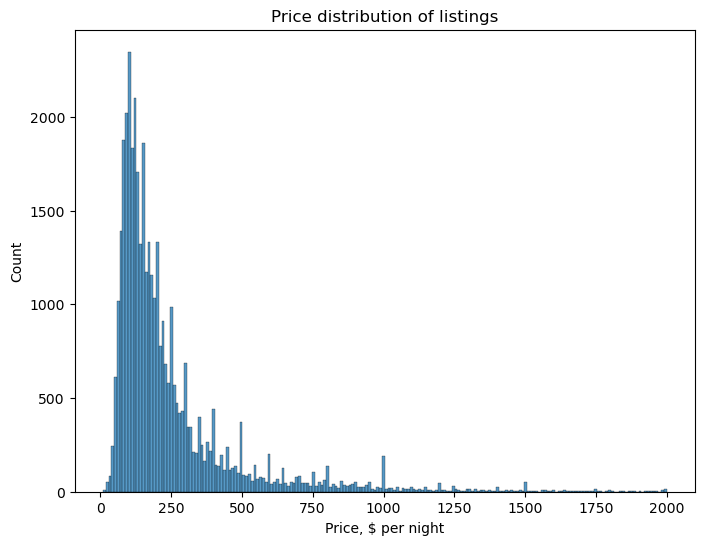

In [215]:
plt.figure(figsize=(8,6))
sns.histplot(df['price'])
plt.xlabel('Price, $ per night')
plt.ylabel('Count')
plt.title('Price distribution of listings');

Price distribution is very right skewed with an average listing of $250 per night and a median price of $170.

## Occupancy rate distribution

Occupancy rate determines the ratio at which that specific property is occupied and is used (along with the price) to calculate the total quarterly income for each listing. 

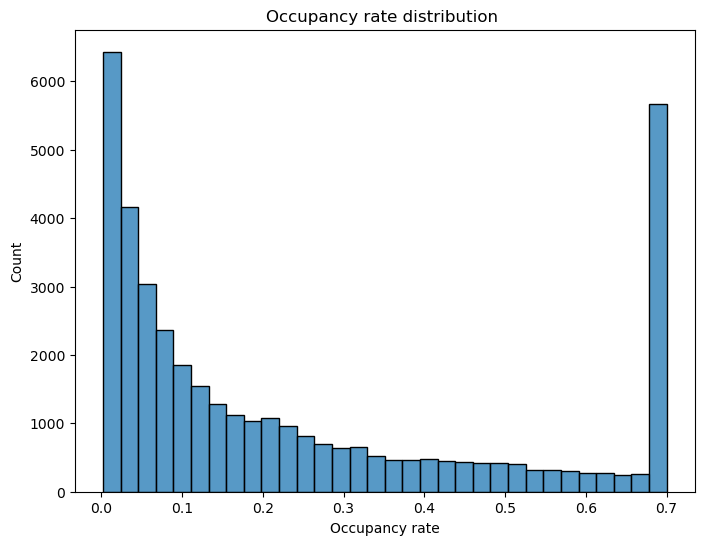

In [216]:
plt.figure(figsize=(8,6))
sns.histplot(df['occupancy_rate'])
plt.xlabel('Occupancy rate')
plt.ylabel('Count')
plt.title('Occupancy rate distribution ');

As discussed in the previous notebook, the occupancy rate is a target variable we have extracted from different factors we had available in our original data. The high value counts for the occupancy rate of 0.7 is because we have set a threshold for the occupancy rate based on the numbers busy short rental properties (like hotels) would usually have. Notice that the distribution of the occupancy rate depends a lot on the assumptions we have made about the behavior of the guests (what percentage of the gets would leave a review after they use the rental property) or what is the average number of nights per booking. 

# Occupancy rate vs. price

While both listing price and occupancy rates are treated as target variables in this study, it could be interesting to see if there is any trends or relation between occupancy rate vs. the listing price. 

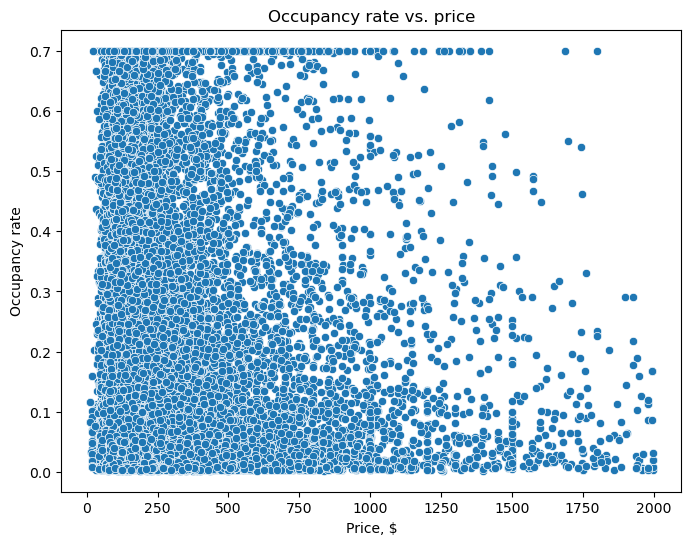

In [217]:
plt.figure(figsize=(8,6))
sns.scatterplot(df, x='price', y='occupancy_rate')
plt.xlabel('Price, $')
plt.ylabel('Occupancy rate')
plt.title('Occupancy rate vs. price');

The above plots shows there is no meaningful trend between these two variables. 

## Zipcode 

Zipcode could be an important factor in determining the price of a listing as neighborhoods that offer more things for the guests are usually the ones that have more demands. Let us first look at the number of listings in each zip code. 

In [218]:
# Convert zip codes to strin
df['zipcode'] = df['zipcode'].astype(str)

In [219]:
print(f'total number of unique zip codes: {df["zipcode"].nunique()}')

total number of unique zip codes: 43


In [220]:
order = df['zipcode'].value_counts(ascending=False).index

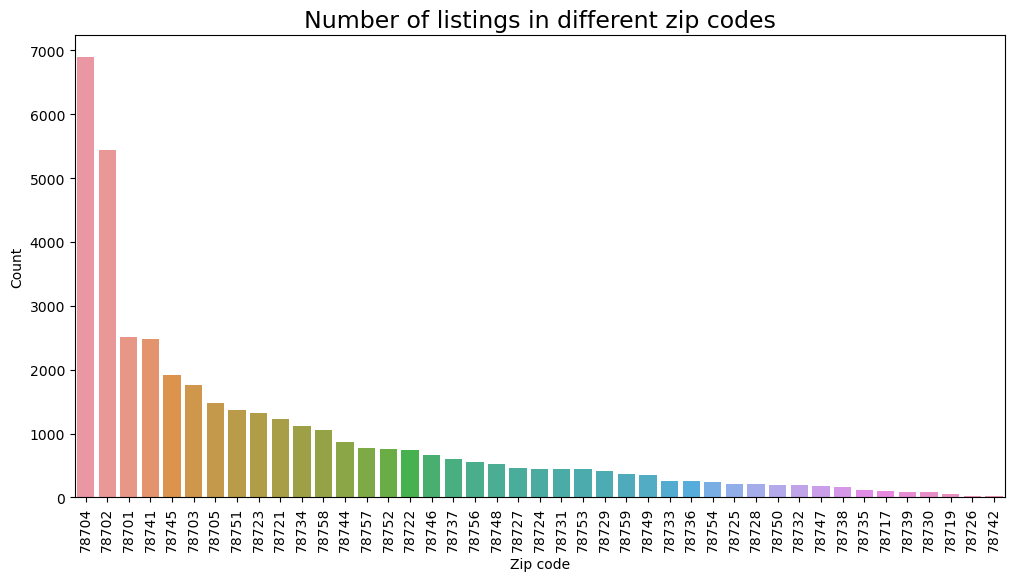

In [221]:
plt.figure(figsize=(12,6))
sns.countplot(data = df, x='zipcode', order=order)
plt.xlabel('Zip code')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Number of listings in different zip codes', size=17);


List the zip codes with the fewest number of listings. We should be cautious to use our model for prediction purposes in these regions as it may not be a good representative of that region due to lack of data. 

In [222]:
df['zipcode'].value_counts(ascending=True).head(10)


78742     21
78726     25
78719     56
78730     83
78739     91
78717     98
78735    112
78738    159
78747    170
78732    189
Name: zipcode, dtype: int64

This plot shows the distribution of house price in each zip code. 

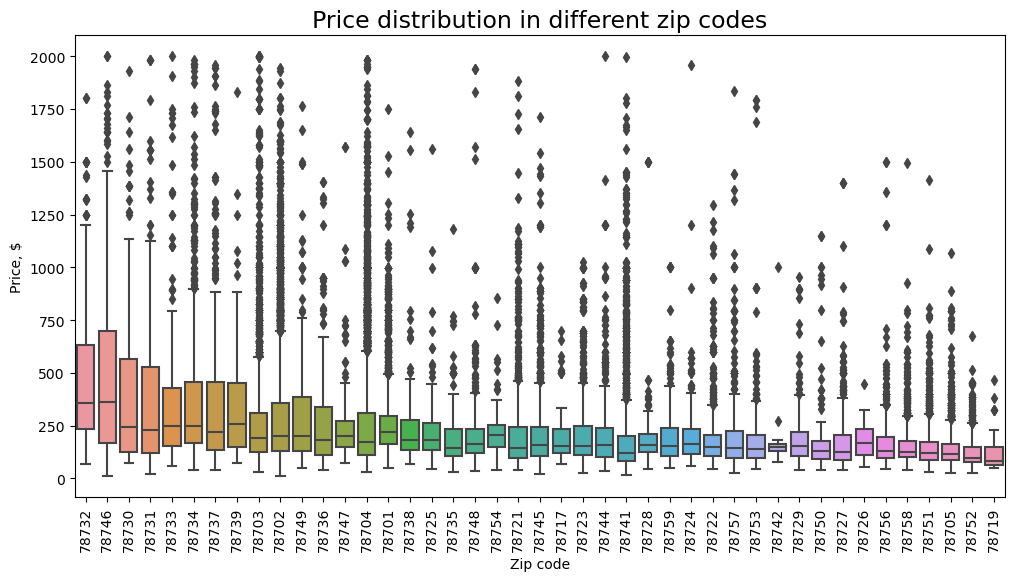

In [223]:
plt.figure(figsize=(12,6))
sns.boxplot(data = df, x='zipcode', y='price', order=df.groupby('zipcode')['price'].mean().sort_values(ascending=False).index)
plt.xlabel('Zip code')
plt.ylabel('Price, $')
plt.xticks(rotation=90)
plt.title('Price distribution in different zip codes', size=17);

This plot does not give us that much of information due to presence of numerous outliers. Let us plot the mean price for each zip code instead. 

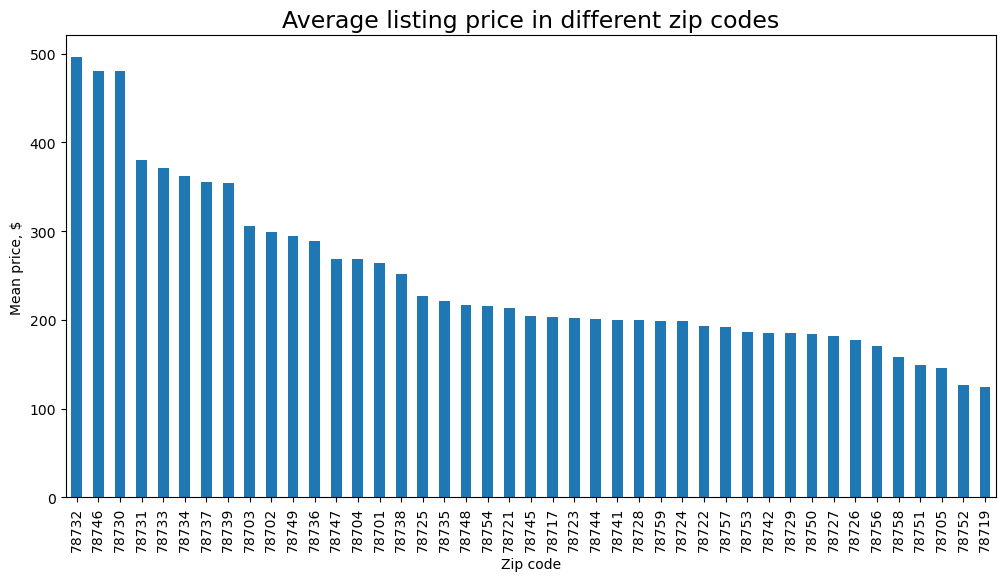

In [224]:
plt.figure(figsize=(12,6))
df.groupby(by='zipcode')['price'].mean().sort_values(ascending=False).plot.bar()
plt.xlabel('Zip code')
plt.ylabel('Mean price, $')
plt.xticks(rotation=90)
plt.title('Average listing price in different zip codes', size=17);

As we can see, the area zip code could have impact on listing price. Now, let us show a map of areas with different average price.

In [225]:
price_zipcode = df.groupby(by='zipcode').mean()[['price']]
price_zipcode['zipcode'] = price_zipcode.index
price_zipcode = price_zipcode.reset_index(drop=True)[['zipcode', 'price']]

C:\Users\masou\AppData\Local\Temp\ipykernel_10736\1440717908.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  price_zipcode = df.groupby(by='zipcode').mean()[['price']]


In [226]:

# create folium object and set the default coordinate and zoom
m = folium.Map(location=[30.26, -97.74], zoom_start=11)
# read the geojson data
city = gpd.read_file('./../data/neighbourhoods.geojson')
folium.Choropleth(
    geo_data=city,
    # create the data that should be used as an overlay
    data=price_zipcode,
    # more on how to plot https://python-visualization.github.io/folium/latest/user_guide/geojson/choropleth.html
    columns=["zipcode", "price"],
    # by looking inside the json file, see where zipcode data is located and address it here
    key_on="feature.properties.neighbourhood",
    # set the colors OrangeRed
    # more info on colors https://python-visualization.github.io/folium/latest/advanced_guide/colormaps.html 
    # https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson.html
    fill_color="OrRd",
    color= "black",
    fill_opacity=0.4,
    line_opacity= 0.9,
    line_weight=1,
    legend_name="Average price, $",
).add_to(m)
m

The highest price belongs the the higher end neighborhoods in the west of the city.

This plot shows the average occupancy rate with zip code. 

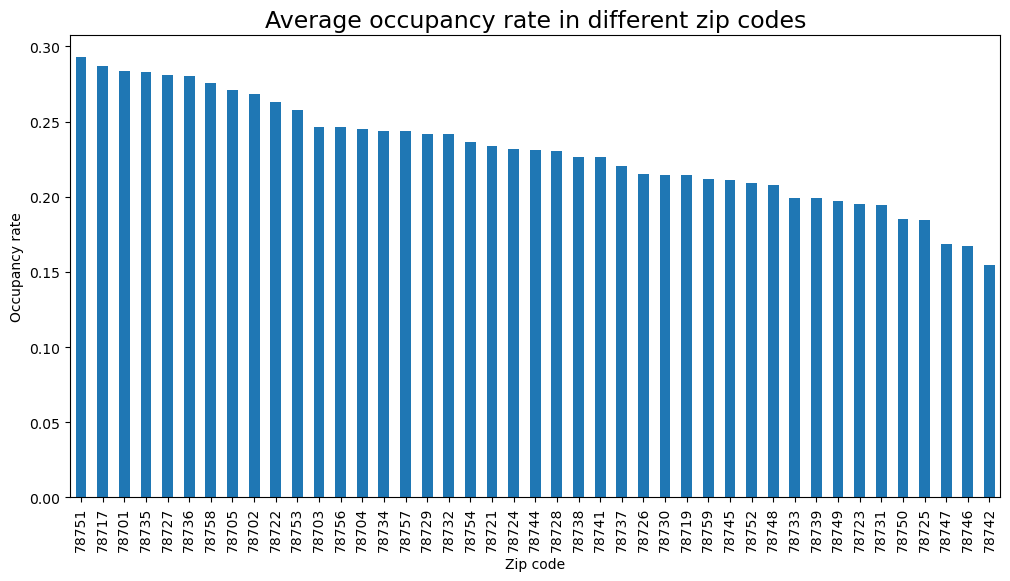

In [227]:
plt.figure(figsize=(12,6))
df.groupby(by='zipcode')['occupancy_rate'].mean().sort_values(ascending=False).plot.bar()
plt.xlabel('Zip code')
plt.ylabel('Occupancy rate')
plt.xticks(rotation=90)
plt.title('Average occupancy rate in different zip codes', size=17);

As we can see, different zip codes have different occupancy rates. The following graph shows how occupancy rate is distributed in different neighborhoods of Austin. 

In [228]:
occupancy_rate_zipcode = df.groupby(by='zipcode').mean()[['occupancy_rate']]
occupancy_rate_zipcode['zipcode'] = occupancy_rate_zipcode.index
occupancy_rate_zipcode = occupancy_rate_zipcode.reset_index(drop=True)[['zipcode', 'occupancy_rate']]

C:\Users\masou\AppData\Local\Temp\ipykernel_10736\120798531.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  occupancy_rate_zipcode = df.groupby(by='zipcode').mean()[['occupancy_rate']]


In [229]:

# create folium object and set the default coordinate and zoom
m = folium.Map(location=[30.26, -97.74], zoom_start=11)
# read the geojson data
city = gpd.read_file('./../data/neighbourhoods.geojson')
folium.Choropleth(
    geo_data=city,
    # create the data that should be used as an overlay
    data=occupancy_rate_zipcode,
    # more on how to plot https://python-visualization.github.io/folium/latest/user_guide/geojson/choropleth.html
    columns=["zipcode", "occupancy_rate"],
    # by looking inside the json file, see where zipcode data is located and address it here
    key_on="feature.properties.neighbourhood",
    # set the colors OrangeRed
    # more info on colors https://python-visualization.github.io/folium/latest/advanced_guide/colormaps.html 
    # https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson.html
    fill_color="OrRd",
    color= "black",
    fill_opacity=0.4,
    line_opacity= 0.9,
    line_weight=1,
    legend_name="Average occupancy rate",
).add_to(m)
m

Regions around the downtown area (in the center), and southwest and northern regions show higher occupancy rates. 

## Host experience

In airbnb terminology, superhost is a term that is used for hosts with higher experience. Superhosts doe have the capability to provide a better experience for the guests as they are usually more cooperative and easier to deal with. In the section, we will see whether being a superhost impacts the price or occupancy rate of the listing. 

In [230]:
df['host_is_superhost'].value_counts()

f    21409
t    17927
Name: host_is_superhost, dtype: int64

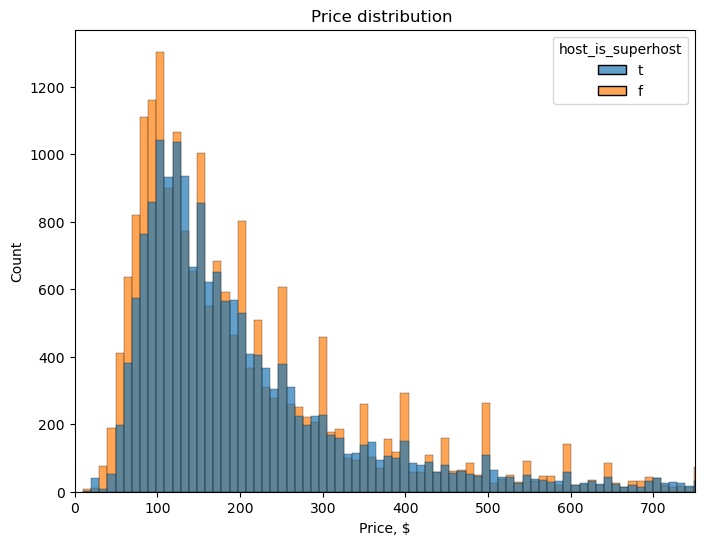

In [231]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='price', hue='host_is_superhost', alpha=.7)
plt.xlabel('Price, $')
plt.xlim((0, 750))
plt.ylabel('Count')
plt.title('Price distribution ');

There is no noticeable change in the price of listings when the host is a superhost.  

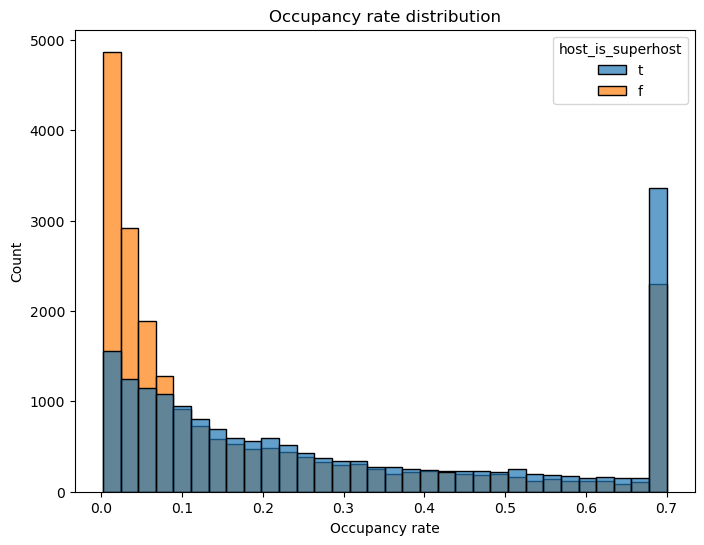

In [232]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='occupancy_rate', hue='host_is_superhost', alpha=.7)
plt.xlabel('Occupancy rate')
plt.ylabel('Count')
plt.title('Occupancy rate distribution');

In [233]:
df.groupby(by='host_is_superhost').mean()['occupancy_rate']

C:\Users\masou\AppData\Local\Temp\ipykernel_10736\2390289804.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(by='host_is_superhost').mean()['occupancy_rate']


host_is_superhost
f    0.199095
t    0.298133
Name: occupancy_rate, dtype: float64

On the other hand, we can see that the occupancy rate is relatively higher for cases where the host is superhost. 

## Number of bedrooms and beds

Number of bedrooms in our features were either in our original scraped data or were extracted from listing name (description).

In [234]:
df['bedrooms'].isna().sum()

455

In [235]:
df['bedrooms'] = df['bedrooms'].astype(float)

In [236]:
df['bedrooms'].value_counts().sort_index()

0.0      1811
1.0     12331
2.0     10995
3.0      8174
4.0      3759
5.0      1132
6.0       375
7.0       162
8.0        64
9.0        32
10.0       25
12.0       10
13.0       12
14.0        2
15.0        2
Name: bedrooms, dtype: int64

Houses with number of bedrooms more than 7 are rarely found and would be considered a very special case of investment. We will limit our investigations to listing with a maximum of 7 bedrooms.

In [237]:
df = df[df['bedrooms'] <= 7]

We see the majority of listings have bedrooms from 0 (studio) to 4. Let us see how the number of beds could impact the housing price. 

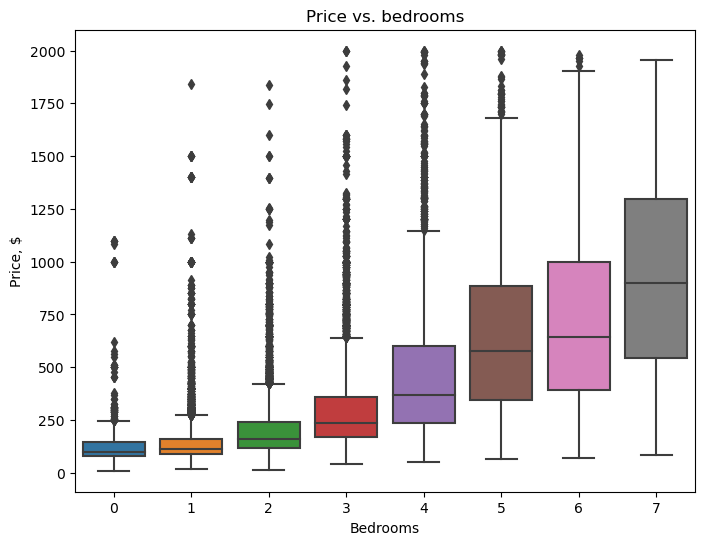

In [238]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='bedrooms', y='price')

# to show the x axis values without decimals
def format_x_ticks(x, _):
    return f'{int(x)}'
# Apply the custom formatter to the x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))

plt.xlabel('Bedrooms')
plt.ylabel('Price, $')
plt.title('Price vs. bedrooms');

We can see average home price increases for the higher number of bedrooms, which was very much expected.

This graph shows the distribution of occupancy rate with number of bedrooms. 

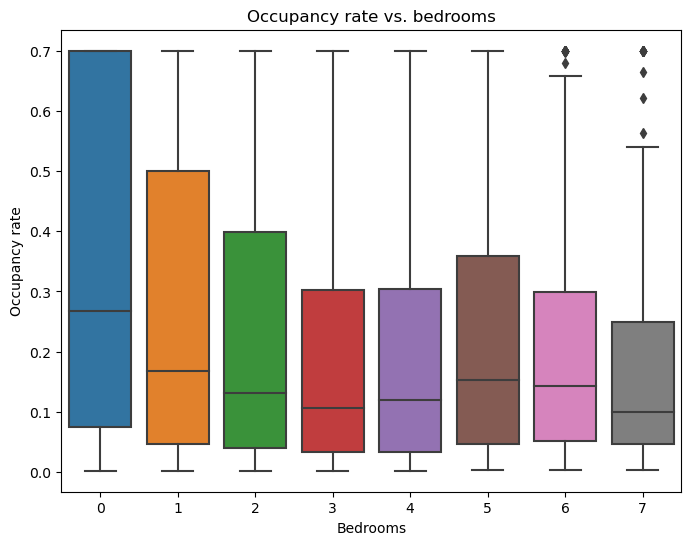

In [239]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='bedrooms', y='occupancy_rate')

# to show the x axis values without decimals
def format_x_ticks(x, _):
    return f'{int(x)}'
# Apply the custom formatter to the x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))

plt.xlabel('Bedrooms')
plt.ylabel('Occupancy rate')
plt.title('Occupancy rate vs. bedrooms');

This graph shows an interesting trend. For cases of studios (0 bedrooms), the occupancy rate spans from 0 to 0.7 with a very uniform distribution. In fact, there are different factors for these cases that determine the occupancy rate. For more number of bedrooms (till 4), we can see the average occupancy decreases as the number of bedrooms increases (there are still some higher occupancies in each of these categories). The occupancy rate increase for the 5 bedroom listings. This could be attributed to the fact that these bigger listings could have been used for larger get togethers and there is a higher demand for such occasions (note that the number of listings with 5 bedroom is 1200 listings which is still a considerable number). Since the number of listings for 6 and 7 bedrooms is not that significant, we will refrain from over analyzing that data. 

Our data has another column as number of beds. The number of beds is usually larger than the number of bedrooms and specifies how many people that house accommodates. 

In [240]:
print(df[['bedrooms', 'beds']].corr())

          bedrooms      beds
bedrooms  1.000000  0.795808
beds      0.795808  1.000000


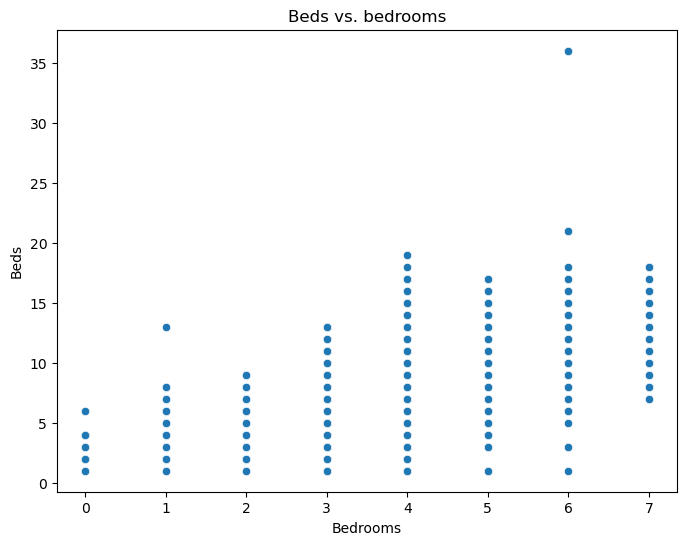

In [241]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='bedrooms', y='beds')

plt.xlabel('Bedrooms')
plt.ylabel('Beds')
plt.title('Beds vs. bedrooms');

We can see there is a correlation between the number of beds and the number of bedrooms, however, we will still keep the beds column and leave the decision to use it in modeling or not to later when we are using models. 

Value counts for the number of beds in our data:

In [242]:
df['beds'].value_counts().sort_index()

1.0      9302
2.0     11342
3.0      7740
4.0      4343
5.0      2113
6.0      1286
7.0       833
8.0       537
9.0       302
10.0      245
11.0      123
12.0      138
13.0       89
14.0       73
15.0       32
16.0       34
17.0       12
18.0       12
19.0        2
21.0        4
36.0        3
Name: beds, dtype: int64

There are a few listings with the number of beds more than 15. As mentioned before, that much of beds is out of scope of this research so we will exclude those listings. 

In [243]:
df = df[df['beds'] < 16]

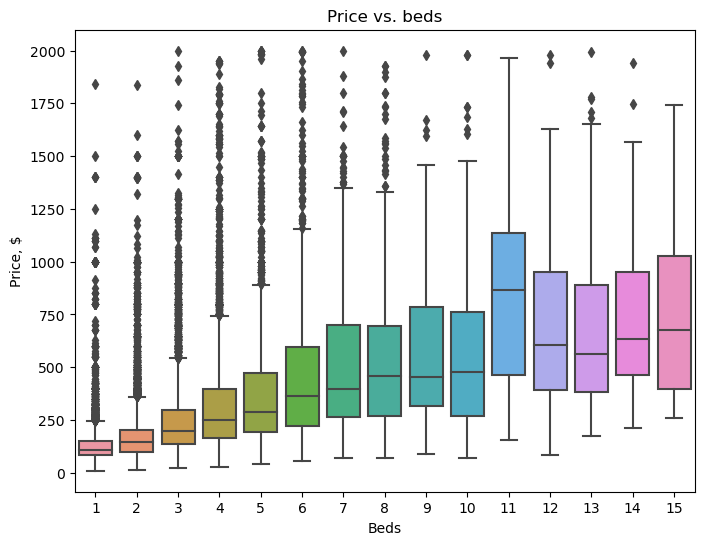

In [244]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='beds', y='price')

# to show the x axis values without decimals
def format_x_ticks(x, _):
    return f'{int(x)+1}'
# Apply the custom formatter to the x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))

plt.xlabel('Beds')
plt.ylabel('Price, $')
plt.title('Price vs. beds');

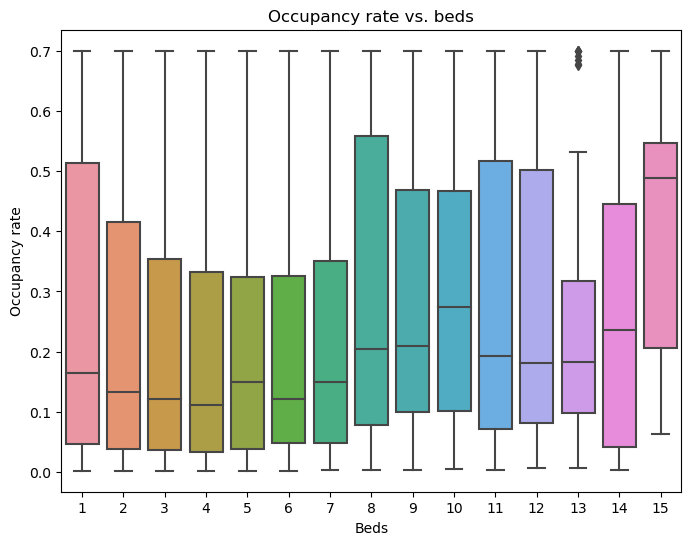

In [245]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='beds', y='occupancy_rate')

# to show the x axis values without decimals
def format_x_ticks(x, _):
    return f'{int(x)+1}'
# Apply the custom formatter to the x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))

plt.xlabel('Beds')
plt.ylabel('Occupancy rate')
plt.title('Occupancy rate vs. beds');

There is a clear trend between the price and number of beds but the occupancy rate does not follow any trends with the number of beds. 

## Number of reviews and review scores

In this section, we will take a look that the number of reviews and the review scores to see if/how they are correlated with price or occupancy rate. 

In [246]:
df['number_of_reviews'].describe()

count    38498.000000
mean        49.849343
std         88.591537
min          1.000000
25%          5.000000
50%         18.000000
75%         53.000000
max       1165.000000
Name: number_of_reviews, dtype: float64

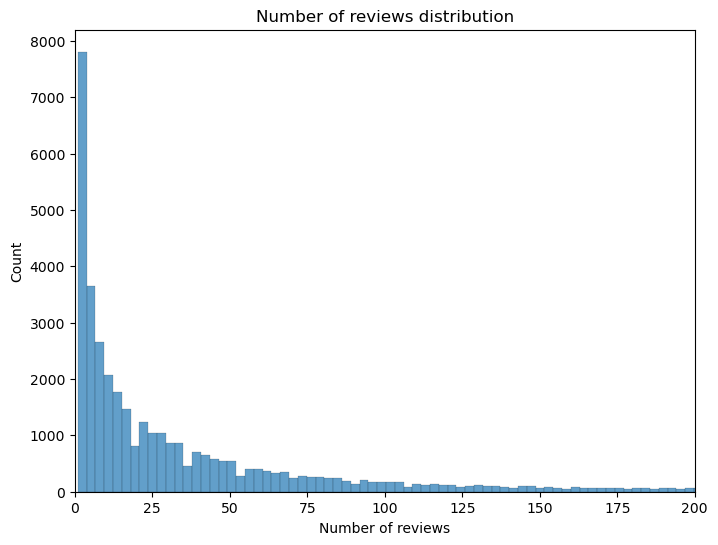

In [247]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='number_of_reviews', alpha=.7)
plt.xlabel('Number of reviews')
plt.xlim((0, 200))
plt.ylabel('Count')
plt.title('Number of reviews distribution');

As we can see, the median for number of reviews is 18 with reviews showing a very fight skewed trend. Let us see if there is any correlation between the number of reviews and price/occupancy rate. 

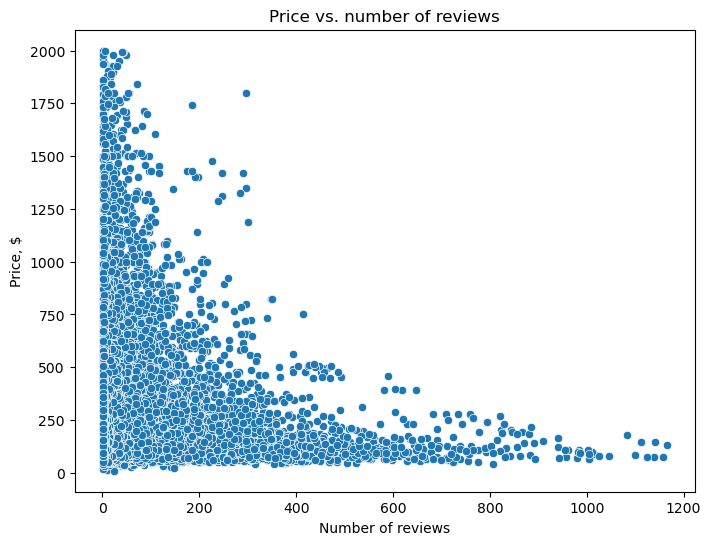

In [248]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='number_of_reviews', y='price')

plt.xlabel('Number of reviews')
plt.ylabel('Price, $')
plt.title('Price vs. number of reviews');

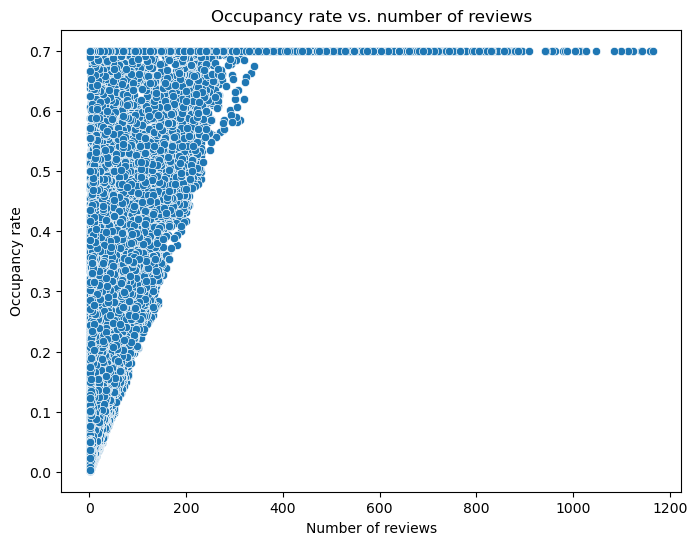

In [249]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='number_of_reviews', y='occupancy_rate')

plt.xlabel('Number of reviews')
plt.ylabel('Occupancy rate')
plt.title('Occupancy rate vs. number of reviews');

From the above plots, we can see that houses that are on the pricier spectrum tend to have fewer number of reviews. On the other hand, low cost houses can have very hight number of reviews. Also, since the number of reviews were used in our occupancy rate calculations, there is a clear trend between the number of reviews and occupancy. Since the number of reviews is not a feature that is readily available or has that much of meaning in it, we have decided not to use it in our model. 

In [250]:
df.drop(columns=['number_of_reviews'], inplace=True)

The following cells show the distribution of the review scores and the outliers.

In [252]:
df['review_scores_rating'].describe()

count    38498.000000
mean         4.805454
std          0.451221
min          0.000000
25%          4.780000
50%          4.930000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64

In [260]:
print('total number of listings with a review score less than 3:')
df[df['review_scores_rating']<3].shape

total number of listings with a review score less than 3:


(331, 17)

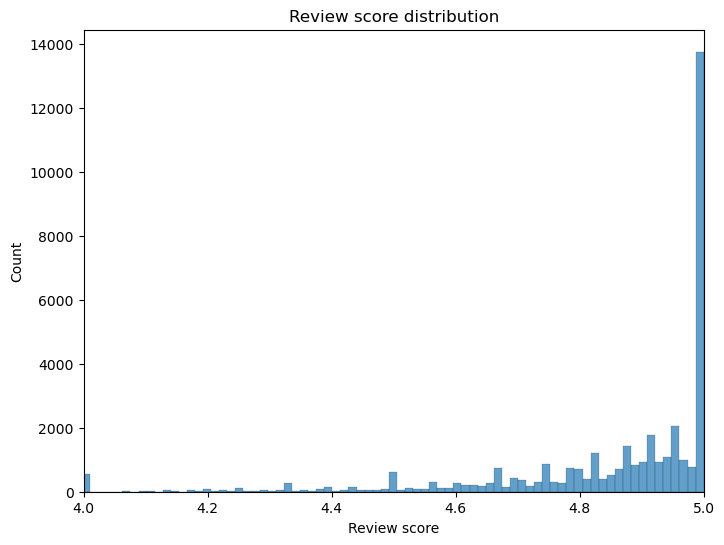

In [261]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='review_scores_rating', alpha=.7)
plt.xlabel('Review score')
plt.xlim((4, 5))
plt.ylabel('Count')
plt.title('Review score distribution');

Our analysis shows that most of the listings in Austin aibnb market get a review of around 4.8 or higher with only 300 listings (out of 40k) having review rating of 3 or less. 

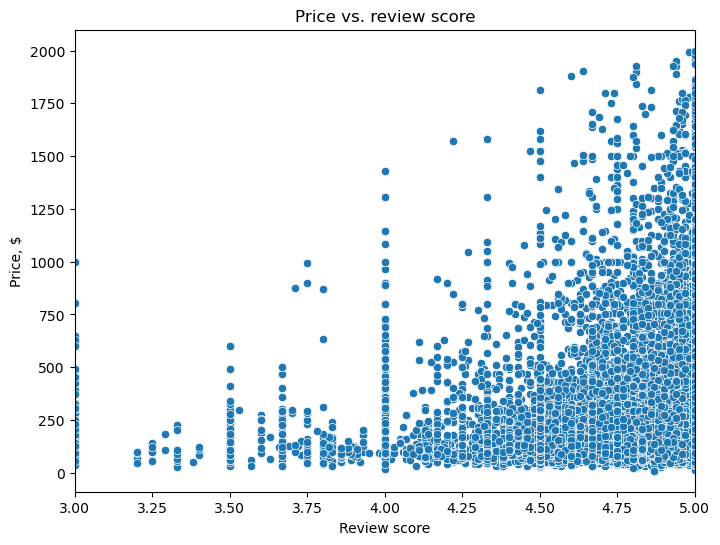

In [268]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='review_scores_rating', y='price')

plt.xlabel('Review score')
plt.xlim((3,5))
plt.ylabel('Price, $')
plt.title('Price vs. review score');

The above plot shows that the pricy houses tend to have a relatively high review ratings. From the plot above and also how review ratings are distributed, it would be very tricky to get anything interesting from the review rating but we will still keep the review rating in our features.

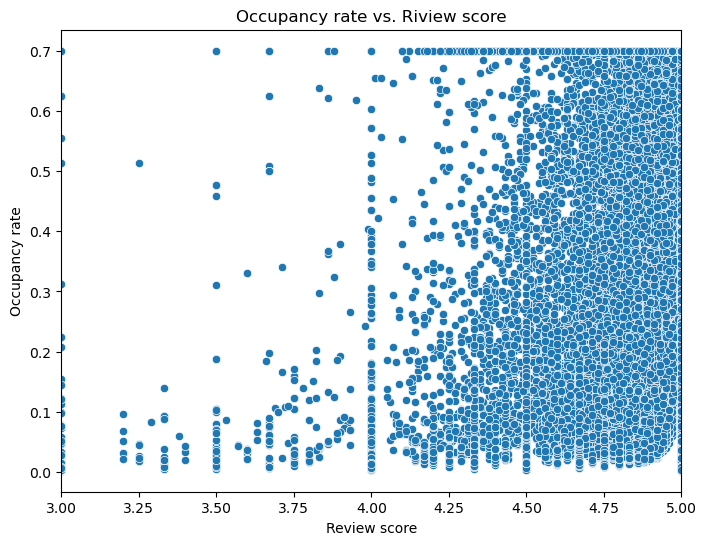

In [267]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='review_scores_rating', y='occupancy_rate')

plt.xlabel('Review score')
plt.xlim((3,5))
plt.ylabel('Occupancy rate')
plt.title('Occupancy rate vs. Riview score');

The above plot does not show any clear relation between review score and occupancy rate. 

## Home price vs. listing price

When thinking about a model to predict listing price for different airbnb listings, one thing that plays role is that the host will usually uses all or part of the income to pay for the home mortgage. So, it could be a reasonable assumption to say the listing price in neighborhoods that are pricier could be higher. Let us investigate that but looking at the listing price vs. property price at different neighborhoods in Austin. `home_price_aprx` column is used for this purpose. 

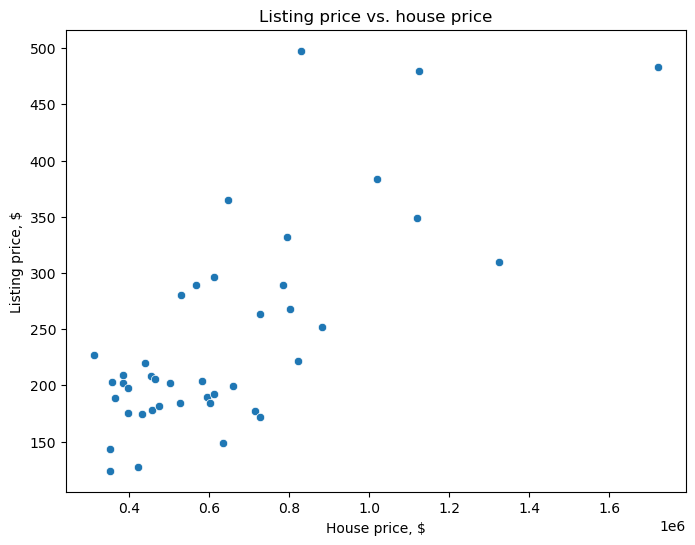

In [282]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df.groupby('home_price_aprx')['price'].mean().index, y=df.groupby('home_price_aprx')['price'].mean().values)

plt.xlabel('House price, $')
plt.ylabel('Listing price, $')
plt.title('Listing price vs. house price');

We will see that the listing price tends to increase in neighborhoods where the house price is higher.

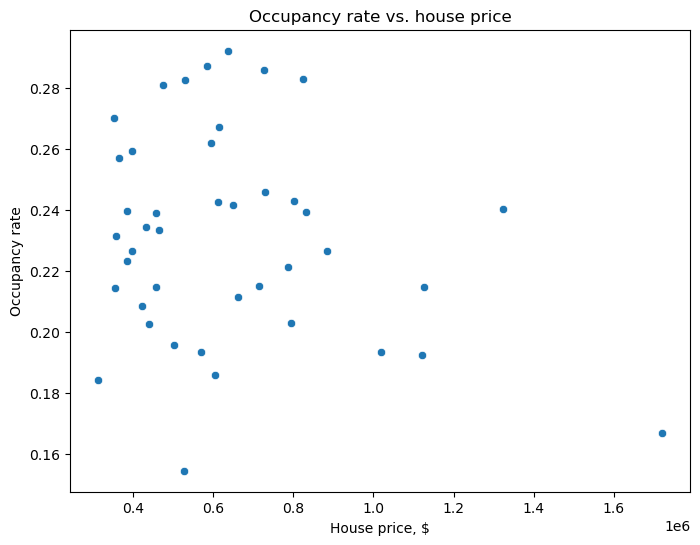

In [285]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df.groupby('home_price_aprx')['occupancy_rate'].mean().index, y=df.groupby('home_price_aprx')['occupancy_rate'].mean().values)

plt.xlabel('House price, $')
plt.ylabel('Occupancy rate')
plt.title('Occupancy rate vs. house price');

Occupancy rate, on the other hand, does not show any correlations with home price. 

## Time of the year

Our data has been scraped 4 times during the course of a year and we have created the column `time_quarter` to specify the time of the listing (quarter). The following plot shows the number of listings in each quarter or the year. 

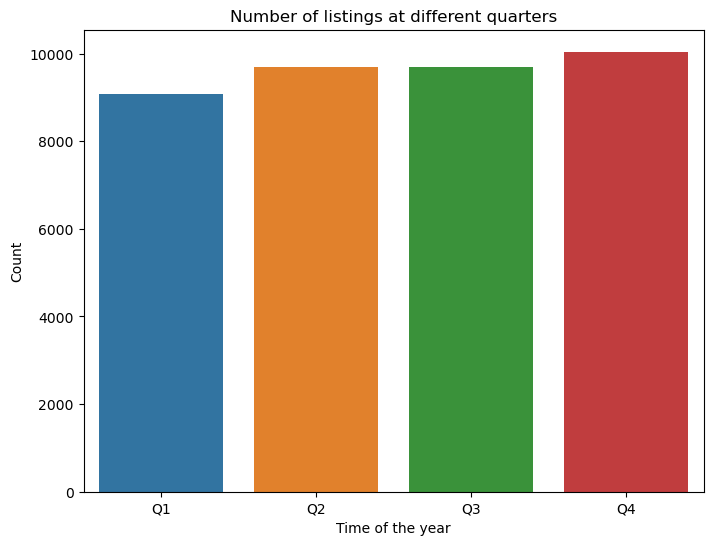

In [289]:
plt.figure(figsize=(8,6))
sns.countplot(data = df, x='time_quarter', order = ['Q1', 'Q2', 'Q3', 'Q4'])
plt.xlabel('Time of the year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.title('Number of listings at different quarters');

The number of listings in all quarters are comparate to each other. Let us see if prices and occupancy rates differ based on which time of the year we want to reserve a place in Austin.

In [294]:
df.groupby('time_quarter')['price'].mean()

time_quarter
Q1    284.316950
Q2    238.235464
Q3    240.367835
Q4    221.423812
Name: price, dtype: float64

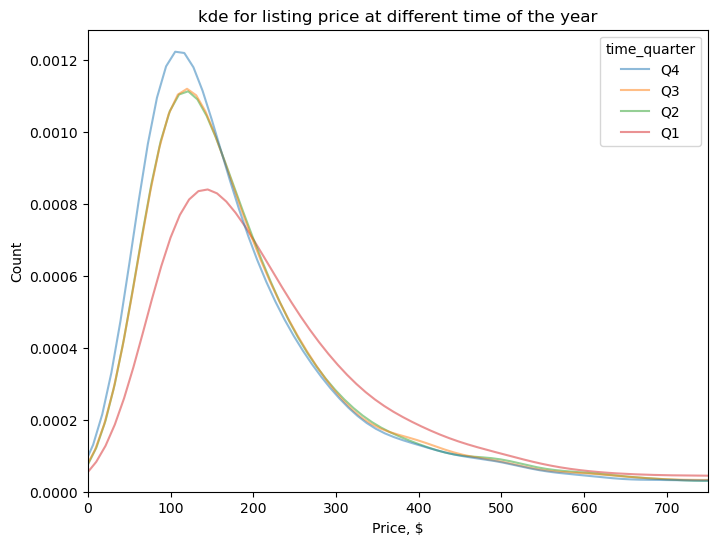

In [301]:
plt.figure(figsize=(8,6))
sns.kdeplot(data=df, x='price',hue='time_quarter', alpha=.5)
plt.xlabel('Price, $')
plt.xlim((0, 750))
plt.ylabel('Count')
#plt.legend(title='Time of the year')
plt.title('kde for listing price at different time of the year');

The average listing price shows a 20% increase in the first quarter of the year (our first quarter starts from Dec 15 as it is when our data is scraped). 

In [302]:
df.groupby('time_quarter')['occupancy_rate'].mean()

time_quarter
Q1    0.238694
Q2    0.246004
Q3    0.245729
Q4    0.243150
Name: occupancy_rate, dtype: float64

As we can see from the above, the occupancy rate does not show any dependency on the time of the year. This was expected because occupancy rate in our study is calculated based on the number of reviews the listings have and it makes it the occupancy rate almost independent of the listing time. This could be some areas for future improvements in our model.  

In [117]:
df.head()

,id,host_is_superhost,zipcode,bedrooms,beds,price,number_of_reviews,review_scores_rating,occupancy_rate,time_quarter,host_id,has_pool,is_petfriendly,has_workspace,has_freeparking,has_gym,home_price_aprx,bath
0,5456,t,78702,1.0,2.0,101.000000,668,4.84,0.700000,Q4,8028,False,False,False,False,False,613000,1
2,6413,f,78704,0.0,1.0,91.666667,120,4.97,0.700000,Q4,13879,False,False,True,False,False,802000,1
3,6448,t,78704,1.0,2.0,159.000000,312,4.97,0.584160,Q4,14156,False,False,True,True,False,802000,1
4,8502,f,78741,1.0,1.0,48.000000,51,4.56,0.100850,Q4,25298,False,True,False,False,False,397000,1
5,13035,t,78702,2.0,2.0,123.000000,18,5.00,0.216998,Q4,50793,False,False,True,False,False,613000,2


## At the end do a pairplot